<a href="https://colab.research.google.com/github/akitim/SkillFactory_projects/blob/main/%D0%9F%D1%80%D0%BE%D0%B5%D0%BA%D1%82_3_%D0%9E_%D0%B2%D0%BA%D1%83%D1%81%D0%BD%D0%BE%D0%B9_%D0%B8_%D0%B7%D0%B4%D0%BE%D1%80%D0%BE%D0%B2%D0%BE%D0%B9_%D0%BF%D0%B8%D1%89%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Проект 3. О вкусной и здоровой пище

In [ ]:
import pandas as pd
 
path = 'https://raw.githubusercontent.com/akitim/datasets/main/main_task_new.csv'
rest = pd.read_csv(path)
 
# 2.1 Задание 1
# Какие столбцы НЕ содержат пропущенных (None) значений?
# rest.info()
 
print('\nЕсть пропуски в столбцах:\n',
*list(rest.loc[:, rest.apply(pd.isna).any(axis=0)].columns))
 
print('\nНет пропусков в столбцах:\n',
*list(rest.loc[:, ~rest.apply(pd.isna).any(axis=0)].columns), '\n')
 
# 2.2 Задание 2
#rest.loc[0, :].apply(type) != str
 
# 2.3 Задание 3
#Приведение 'кухни' к списку
#rest.loc[0, 'Cuisine Style'].split(', ')
#[s.replace('[', '').replace(']', '').replace("'", "") for s in rest.loc[0, 'Cuisine Style'].split(', ')]
 
rest.columns = ['id', 'city', 'cuisine', 'ranking', 'rating', 'price_range', 'rev_number', 'reviews', 'url_TA', 'id_TA']
rest.head(5)


Есть пропуски в столбцах:
 Cuisine Style Price Range Number of Reviews

Нет пропусков в столбцах:
 Restaurant_id City Ranking Rating Reviews URL_TA ID_TA 



,id,city,cuisine,ranking,rating,price_range,rev_number,reviews,url_TA,id_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


#Ответы на вопросы заданий

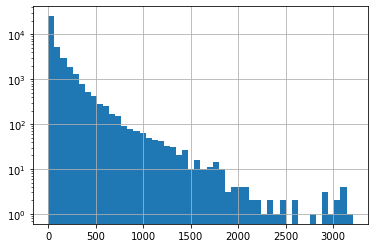

In [15]:
import pandas as pd
import numpy as np
# rest.loc[0:100, 'reviews'].to_list()
path = 'https://raw.githubusercontent.com/akitim/datasets/main/main_task_new.csv'
rest = pd.read_csv(path)

rest.columns = ['id', 'city', 'cuisine', 'ranking', 'rating', 'price_range', 'rev_number', 'reviews', 'url_TA', 'id_TA']

# 4.1 Вопросы о ценах
rest.loc[:, 'price_range'].dropna().unique()
rest.loc[rest.loc[:, 'price_range'] == '$$ - $$$', 'price_range'].count()

# 4.2 Вопрос о городах
len(rest.loc[:, 'city'].unique())

# 4.3 Вопросы о кухнях
rest.loc[:, 'cuisine'] =\
rest.loc[:, 'cuisine'].fillna(value='[]').apply(
    lambda cuisine_list_for_id: \
    [s.replace("'", "") for s in cuisine_list_for_id[2:-2].split(', ')]\
)

cuisine_list = []
for x in rest.loc[:, 'cuisine']:
    cuisine_list += x
len(set(cuisine_list).difference(set([''])))

from collections import Counter
Counter(cuisine_list).most_common(1)[0][0]

round(
    rest.loc[:, 'cuisine'].apply(lambda x: len(x) if x != [] else 1).mean(),
    1
)

# 4.4 Вопросы об отзывах
import re
from datetime import datetime as dat

def rev_dates(s):
    date_regex = re.compile(r'(\d+/\d+/\d+)') # компилируем регулярку для поиска дат в формате dd/mm/YYYY
    str_date_ls = date_regex.findall(s)
    if str_date_ls != []:
        # str_date_ls = date_regex.findall(s)
        enum = list(enumerate(str_date_ls))
        # f = ['%m/%d/%Y' if int(str_date_ls[0][0:2].replace('/', '')) <= 12 else '%d/%m/%Y',
        #      '%m/%d/%Y' if int(str_date_ls[1][0:2].replace('/', '')) <= 12 else '%d/%m/%Y']
        f = ['%m/%d/%Y' if int(e[1][0:2].replace('/', '')) <= 12 else '%d/%m/%Y' for e in enum]
        return [dat.strptime(e[1], f[e[0]]) for e in enum] #dat.strptime(str_date_ls[0], f[0])
    else:
        return [dat(1970, 1, 1, 0, 0), dat(1970, 1, 1, 0, 0)] #strftime('%m/%d/%Y', '01/01/1970')

# когда был оставлен самый свежий отзыв? Введите ответ в формате yyyy-mm-dd.
most_recent_rev_date =\
rest.loc[:, 'reviews'].apply(lambda s: rev_date(s)[0]).max()
dat.strftime(most_recent_rev_date, '%Y-%m-%d') #->2018-02-26

# Какое максимальное количество дней отделяет даты публикации отзывов,
# размещённых на сайте ресторана? Введите количество дней в виде целого числа.
def last_rev_date_delta(dates):
    if len(dates) >= 3:
        return abs(dates[2] - dates[1])
    else:
        return abs(dates[0] - dates[-1])

rest.loc[:, 'delta'] =\
rest.loc[:, 'reviews'].apply(lambda s: last_rev_date_delta(rev_dates(s))); #.sort_values(ascending=False)
rest['delta'].dt.days.astype(int).hist(log=True, bins=50);

#Черновик 1

In [38]:
# import re
# from datetime import datetime as dat

# date_regex.findall(s)[0][0:2] <\
# date_regex.findall(s)[0][3:5] #->11 #->18

st = "[['Best place to try a Bavarian food', 'Nice building but improvements need to be...'], ['11/18/2017', '02/19/2017']]"
# rev_date(s)
date_regex = re.compile(r'(\d+/\d+/\d+)') # компилируем регулярку для поиска дат в формате dd/mm/YYYY
str_date_ls = date_regex.findall(st)

# if str_date_ls != []:
#     str_date_ls = date_regex.findall(s)
#     enum = enumerate(str_date_ls)
# #     f = ['%m/%d/%Y' if int(str_date_ls[0][0:2].replace('/', '')) <= 12 else '%d/%m/%Y',
# #          '%m/%d/%Y' if int(str_date_ls[1][0:2].replace('/', '')) <= 12 else '%d/%m/%Y']
#     f = ['%m/%d/%Y' if int(e[1][0:2].replace('/', '')) <= 12 else '%d/%m/%Y' for e in enum]
#     r = [dat.strptime(e[1], f[e[0]]) for e in enum] #dat.strptime(str_date_ls[0], f[0])
# r
if True:
    date_regex = re.compile(r'(\d+/\d+/\d+)') # компилируем регулярку для поиска дат в формате dd/mm/YYYY
    str_date_ls = date_regex.findall(st)
    if str_date_ls != []:
        enum = list(enumerate(str_date_ls))
        # f = ['%m/%d/%Y' if int(str_date_ls[0][0:2].replace('/', '')) <= 12 else '%d/%m/%Y',
        #      '%m/%d/%Y' if int(str_date_ls[1][0:2].replace('/', '')) <= 12 else '%d/%m/%Y']
        f = ['%m/%d/%Y' if int(e[1][0:2].replace('/', '')) <= 12 else '%d/%m/%Y' for e in enum]
        r=[dat.strptime(e[1], f[e[0]]) for e in enum] #dat.strptime(str_date_ls[0], f[0])
    else:
        r=[dat(1970, 1, 1, 0, 0), dat(1970, 1, 1, 0, 0)] #strftime('%m/%d/%Y', '01/01/1970')

# rev_date(st)
# str_date_ls, f, enum
# se = rest.loc[:, 'reviews'].apply(lambda s: len(rev_date(s)))
# rest[se==1]['reviews']
# rest.loc[[9254, 23348], 'reviews'].to_list()
# rest.loc[rest.loc[:, 'reviews'].apply(lambda s: ("'], ['" in s) or (s == "[[], []]")), 'reviews'].index.to_list()
se = rest.loc[:, 'reviews'].apply(lambda s: s.count('['))
rest[se!=3]['reviews'].to_list()

["[['Good food, attentive staff', 'Sternstraße 125, Schanzenviertel, [59], ju...'], ['05/10/2015', '07/05/2014']]",
 "[['Nice lunch for a hungry group[ of travelle...', 'Tasty salad and sandwich'], ['10/24/2017', '01/12/2017']]",
 "[['Veramente Italiano [Really Italian]', 'Lunch on a Sunday'], ['12/11/2017', '11/19/2017']]"]

In [ ]:
#Предобработка
# rest.loc[0, :].apply(type)
# rest.dropna(axis=0, inplace=True)

rest.loc[:, 'cuisine'] =\
rest.loc[:, 'cuisine'].apply(
    lambda cuisine_list_for_id: \
        [s.replace("'", "") for s in cuisine_list_for_id[2:-2].split(', ')]\
            if not(pd.isna(cuisine_list_for_id)) else []
)

            # rest.loc[0, 'Cuisine Style'][0]
            # rest.get_dummies()
rest

#Черновик 2

In [ ]:
# pd.get_dummies(rest, columns=['Cuisine Style'])
# rest.loc[rest.loc[:, 'Cuisine Style'].apply(lambda r: pd.isna(r)), 'Cuisine Style']

mean_NoR = rest.loc[:, 'Number of Reviews'].mean()
rest.loc[:, 'Number of Reviews'] = \
rest.loc[:, 'Number of Reviews'].apply(lambda r: r if not(pd.isna(r)) else mean_NoR)

rest_m = rest.loc[:, ['Ranking', 'Number of Reviews']]


#Линейная регрессия

In [ ]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
    # Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)  
# X = rest.drop(['Restaurant_id', 'Rating'], axis = 1)  
X = rest_m
y = rest.loc[:, 'Rating']
      
    # Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
      
    # Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
    # Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
      
    # Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
    # Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
    # Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.  
    # Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  
 
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются  
    # Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.  
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))